In [2]:
from __future__ import print_function

import sys
import os
import time
import string
import random
import pickle

import numpy as np
import theano
import theano.tensor as T
import lasagne

from sklearn.decomposition import PCA
import multiprocessing

/Users/arjunbhagoji/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def load_data():
    xs = []
    ys = []
    for j in range(5):
      d = unpickle(abs_path_i+'cifar-10-batches-py/data_batch_'+`j+1`)
      x = d['data']
      y = d['labels']
      xs.append(x)
      ys.append(y)

    d = unpickle(abs_path_i+'cifar-10-batches-py/test_batch')
    xs.append(d['data'])
    ys.append(d['labels'])

    x = np.concatenate(xs)/np.float32(255)
    y = np.concatenate(ys)
    x = np.dstack((x[:, :1024], x[:, 1024:2048], x[:, 2048:]))
    x = x.reshape((x.shape[0], 32, 32, 3)).transpose(0,3,1,2)

    # subtract per-pixel mean
    pixel_mean = np.mean(x[0:50000],axis=0)
    #pickle.dump(pixel_mean, open("cifar10-pixel_mean.pkl","wb"))
    #x -= pixel_mean

    # create mirrored images
    X_train = x[0:50000,:,:,:]
    Y_train = y[0:50000]
    # X_train_flip = X_train[:,:,:,::-1]
    # Y_train_flip = Y_train
    # X_train = np.concatenate((X_train,X_train_flip),axis=0)
    # Y_train = np.concatenate((Y_train,Y_train_flip),axis=0)

    X_test = x[50000:,:,:,:]
    Y_test = y[50000:]

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        Y_train=Y_train.astype('int32'),
        X_test = lasagne.utils.floatX(X_test),
        Y_test = Y_test.astype('int32'),)

In [25]:
def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 3, rd),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # 2 Convolutional layers with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 64 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=128, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=128, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(lasagne.layers.dropout(network, p=.5),
                                        num_units=256,
                                    nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.DenseLayer(lasagne.layers.dropout(network, p=.5),
                                        num_units=256,
                                    nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(lasagne.layers.dropout(network, p=.5),
                                        num_units=10,
                                    nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [26]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            # as in paper :
            # pad feature arrays with 4 pixels on each side
            # and do random cropping of 32x32
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.random_integers(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

In [4]:
script_dir=os.getcwd()
rel_path_i="Input_data/"
abs_path_i=os.path.join(script_dir,rel_path_i)
rel_path_m="Models/"
abs_path_m=os.path.join(script_dir,rel_path_m)
rel_path_o="Output_data/"
abs_path_o=os.path.join(script_dir,rel_path_o)

In [5]:
# Load the dataset
print("Loading data...")
data = load_data()
X_train = data['X_train']
Y_train = data['Y_train']
X_test = data['X_test']
Y_test = data['Y_test']

Loading data...


In [6]:
X_train.shape

(50000, 3, 32, 32)

In [7]:
X_train[0].shape

(3, 32, 32)

In [8]:
from matplotlib import pyplot as plt

In [9]:
%matplotlib inline

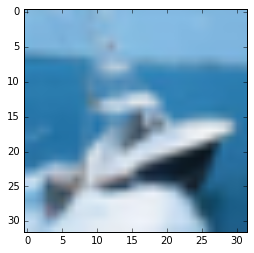

In [24]:
plt.imshow(X_train[8].transpose(1,2,0))

In [43]:
Y_train[2]

9

In [49]:
X_train[0:2,0,:,:]

array([[[ 0.23137255,  0.16862746,  0.19607843, ...,  0.61960787,
          0.59607846,  0.58039218],
        [ 0.0627451 ,  0.        ,  0.07058824, ...,  0.48235294,
          0.46666667,  0.47843137],
        [ 0.09803922,  0.0627451 ,  0.19215687, ...,  0.4627451 ,
          0.47058824,  0.42745098],
        ..., 
        [ 0.81568629,  0.78823531,  0.7764706 , ...,  0.627451  ,
          0.21960784,  0.20784314],
        [ 0.70588237,  0.67843139,  0.72941178, ...,  0.72156864,
          0.38039216,  0.32549021],
        [ 0.69411767,  0.65882355,  0.7019608 , ...,  0.84705883,
          0.59215689,  0.48235294]],

       [[ 0.60392159,  0.49411765,  0.41176471, ...,  0.35686275,
          0.34117648,  0.30980393],
        [ 0.54901963,  0.56862748,  0.49019608, ...,  0.3764706 ,
          0.3019608 ,  0.27843139],
        [ 0.54901963,  0.54509807,  0.4509804 , ...,  0.30980393,
          0.26666668,  0.26274511],
        ..., 
        [ 0.68627453,  0.61176473,  0.60392159, ...,

In [48]:
X_train[0:2,0,:,:].reshape((2,1024))

array([[ 0.23137255,  0.16862746,  0.19607843, ...,  0.84705883,
         0.59215689,  0.48235294],
       [ 0.60392159,  0.49411765,  0.41176471, ...,  0.56078434,
         0.56078434,  0.56078434]])

In [50]:
X_train_c0=X_train[:,0,:,:].reshape((50000,1024))
X_train_c1=X_train[:,1,:,:].reshape((50000,1024))
X_train_c2=X_train[:,2,:,:].reshape((50000,1024))

X_test_c0=X_test[:,0,:,:].reshape((10000,1024))
X_test_c1=X_test[:,1,:,:].reshape((10000,1024))
X_test_c2=X_test[:,2,:,:].reshape((10000,1024))

In [52]:
pca_c0=PCA(n_components=100)
pca_c1=PCA(n_components=100)
pca_c2=PCA(n_components=100)
#Fitting the PCA model on training data
pca_train_c0=pca_c0.fit(X_train_c0)
pca_train_c1=pca_c1.fit(X_train_c1)
pca_train_c2=pca_c2.fit(X_train_c2)

In [53]:
X_train_c0_dr=pca_c0.transform(X_train_c0)
X_train_c1_dr=pca_c1.transform(X_train_c1)
X_train_c2_dr=pca_c2.transform(X_train_c2)

In [54]:
X_train_c0_dr.shape

(50000, 100)

In [60]:
mean_vec=np.mean(X_train_c0,axis=0)

In [61]:
mean_vec.shape

(1024,)

In [64]:
a=np.array([mean_vec,]*50000)

In [63]:
mean_vec

array([ 0.51259115,  0.51035436,  0.5139233 , ...,  0.49717005,
        0.49633319,  0.49662385])

In [65]:
X_train_c0-a

array([[-0.2812186 , -0.34172691, -0.31784487, ...,  0.34988878,
         0.0958237 , -0.01427091],
       [ 0.09133045, -0.01623672, -0.10215859, ...,  0.06361429,
         0.06445115,  0.06416049],
       [ 0.48740885,  0.4818025 ,  0.47823356, ..., -0.19128769,
        -0.18652925, -0.18289835],
       ..., 
       [-0.37533624, -0.35349161, -0.34921742, ..., -0.3912877 ,
        -0.41398024, -0.44956503],
       [ 0.22858534,  0.21905742,  0.21156691, ...,  0.26753585,
         0.27229428,  0.26808204],
       [ 0.38544807,  0.41513584,  0.40372376, ...,  0.20479075,
         0.14680409,  0.14259185]])